In [1]:
import glob
import os
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
import pandas as pd
data_dir = 'data_meg'
subj = "R2490"
dataqual = 'prepro' #or loc/exp
exp = 'exp' #or exp
dtype = "raw"
label_dir = 'data_log'
raw = mne.io.read_raw_fif('data_meg/R2490/prepro/R2490_exp.fif', preload=True)
save_dir = 'data_meg'



Opening raw data file data_meg/R2490/prepro/R2490_exp.fif...


/var/folders/79/m99pb_8d67l3d79st4zhf4tc0000gn/T/ipykernel_13859/78549124.py:15: RuntimeWarning: This filename (data_meg/R2490/prepro/R2490_exp.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif('data_meg/R2490/prepro/R2490_exp.fif', preload=True)


    Range : 0 ... 2779999 =      0.000 ...  2779.999 secs
Ready.
Opening raw data file /Users/dorisyu/meg_decoding/data_meg/R2490/prepro/R2490_exp-1.fif...
    Range : 2780000 ... 3669999 =   2780.000 ...  3669.999 secs
Ready.
Reading 0 ... 3669999  =      0.000 ...  3669.999 secs...


In [2]:
sfreq = raw.info['sfreq']
raw.filter(1, 40, method='iir')
downsample = 10

Filtering raw data in 2 contiguous segments
Setting up band-pass filter from 1 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 40.00 Hz: -6.02, -6.02 dB



In [3]:
events = mne.find_events(raw, stim_channel='STI 014', output='onset', shortest_event=1)
event_id = {
    'start': 160,
    'move': 161,
    'reveal_red': 162,
    'reveal_white': 163,
    'done': 164,
    'choice': 165,
    'timeout': 166
}

# Define trials to remove
trials_to_remove = []

4032 events found on stim channel STI 014
Event IDs: [160 161 162 163 164 166]


In [21]:
start_events = events[events[:, 2] == event_id['start']]
done_events = events[events[:, 2] == event_id['done']]
timeout_events = events[events[:, 2] == event_id['timeout']]
reveal_red_events = events[events[:, 2] == event_id['reveal_red']]
reveal_white_events = events[events[:, 2] == event_id['reveal_white']]
sfreq = raw.info['sfreq']  # Sampling frequency

# Combine 'done' and 'timeout' events
end_events = np.concatenate((done_events, timeout_events))
end_events = end_events[end_events[:, 0].argsort()]  # Sort by time

# Initialize a list to store trial information
trial_info = []
previous_start_sample = None
processed_starts = set()
start_idx = 0

# Iterate through each start event to create trial information
for idx, start_event in enumerate(start_events):
    start_sample = start_event[0]

    # Find the next end event after the start event
    end_idx = np.searchsorted(end_events[:, 0], start_sample, side='right')
    if end_idx < len(end_events):
        end_sample = end_events[end_idx, 0]

        # Check if the current start is at least 20 seconds after the previous start
        if (previous_start_sample is None or (start_sample - previous_start_sample) / sfreq >= 20) and start_sample not in processed_starts:
            # Proceed with processing this start event
            previous_start_sample = start_sample
            processed_starts.add(start_sample)  # Add to the set of processed starts

            # Calculate tmin and tmax for the epoch
            tmin = -0.2  # 0.2 s before 'start'
            tmax = (end_sample - start_sample) / sfreq + 1.0  # Duration from 'start' to 1 s after end event
            print(f"tmax is {tmax}")

            reveal_red_within_trial = reveal_red_events[(reveal_red_events[:, 0] > start_sample) & 
                                                        (reveal_red_events[:, 0] < end_sample)]
            reveal_white_within_trial = reveal_white_events[(reveal_white_events[:, 0] > start_sample) & 
                                                            (reveal_white_events[:, 0] < end_sample)]

            # Store trial information, including whether 'reveal_red' and 'reveal_white' occurred
            trial_info.append({
                'event_sample': start_sample,
                'trial_index': start_idx,
                'duration': tmax,
                'tmin': tmin,
                'tmax': tmax,
                'done': len(done_events) > 0,
                'start_times': start_sample / sfreq,
                'reveal_red': len(reveal_red_within_trial) > 0,  # Boolean flag indicating if 'reveal_red' occurred
                'reveal_red_times': (reveal_red_within_trial[:, 0] - start_sample) / sfreq if len(reveal_red_within_trial) > 0 else [],
                'reveal_white': len(reveal_white_within_trial) > 0,  # Boolean flag indicating if 'reveal_white' occurred
                'reveal_white_times': (reveal_white_within_trial[:, 0] - start_sample) / sfreq if len(reveal_white_within_trial) > 0 else [],
                'reveal_times': sorted(
                    ((reveal_red_within_trial[:, 0] - start_sample) / sfreq).tolist() +
                    ((reveal_white_within_trial[:, 0] - start_sample) / sfreq).tolist()
                )
            })
            start_idx += 1

tmax is 10.37
tmax is 20.844
tmax is 18.367
tmax is 30.148
tmax is 30.108
tmax is 17.427
tmax is 26.046
tmax is 16.14
tmax is 30.086
tmax is 5.747
tmax is 30.131
tmax is 18.861
tmax is 30.1
tmax is 22.326
tmax is 6.579
tmax is 30.131
tmax is 9.428
tmax is 14.223
tmax is 16.57
tmax is 30.098
tmax is 15.21
tmax is 30.097
tmax is 6.829
tmax is 6.479
tmax is 30.126
tmax is 6.632
tmax is 30.104
tmax is 5.687
tmax is 13.794
tmax is 15.89
tmax is 6.895
tmax is 30.108
tmax is 22.915
tmax is 21.546
tmax is 18.657
tmax is 8.503
tmax is 10.664
tmax is 8.812000000000001
tmax is 11.69
tmax is 30.128
tmax is 12.511
tmax is 9.211
tmax is 10.74
tmax is 30.154
tmax is 23.313
tmax is 6.251
tmax is 21.454
tmax is 15.693
tmax is 8.02
tmax is 30.13
tmax is 16.454
tmax is 13.888
tmax is 23.994
tmax is 13.911
tmax is 10.327
tmax is 30.133
tmax is 15.794
tmax is 14.118
tmax is 17.522
tmax is 10.095
tmax is 30.111
tmax is 15.147
tmax is 17.24
tmax is 6.929
tmax is 30.087
tmax is 30.116
tmax is 6.065
tmax is 30

In [5]:
new_events = np.array([[info['event_sample'], 0, event_id['start']] for info in trial_info])
tmin = -0.2  
# Initialize lists to store individual epochs data and trial information
epochs_data_list = []
trial_info_valid = []

In [22]:
# Iterate over new_events and create epochs, skipping the unwanted trials
for idx, event in enumerate(new_events):
    start_sample = event[0]
    event_id_code = event[2]
    event_time = start_sample / sfreq
    total_duration = raw.times[-1]
    print(f"Tmax is {tmax}")
    # Create the epoch
    epochs = mne.Epochs(
        raw, [event], event_id={f'event_{event_id_code}': event_id_code},
        tmin=tmin, tmax=26, preload=True,
        reject_by_annotation=False, reject=None, verbose=True
    )

    # Append valid epochs to the list
    if len(epochs) > 0:
        epochs_data_list.append(epochs.get_data()[:, :, ::downsample])
        trial_info_valid.append(trial_info[idx])
    else:
        print(f"Epoch {idx} was dropped.")
        print(f"Drop log for Epoch {idx}: {epochs.drop_log}")


Tmax is 30.103
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 26201 original time points ...
0 bad epochs dropped
Tmax is 30.103
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 26201 original time points ...
0 bad epochs dropped
Tmax is 30.103
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 26201 original time points ...
0 bad epochs dropped
Tmax is 30.103
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using d

In [7]:
len(epochs_data_list)

120

## Decoding

In [8]:
from mne.decoding import SlidingEstimator, cross_val_multiscore, Vectorizer
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from matplotlib import pyplot as plt
label_encoder = LabelEncoder()
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score


In [9]:
labels_df = pd.read_csv(f'{label_dir}/{subj}/label.csv')

# Step 1: Get the valid trial indices
valid_trial_indices = {info['trial_index'] for info in trial_info_valid}

# Step 2: Filter labels_df to only include valid trial indices
labels_df_filtered = labels_df[labels_df['trial_index'].isin(valid_trial_indices)]
label_dict = dict(zip(labels_df_filtered['trial_index'], labels_df_filtered['trial.rule']))

# Step 3: Extract labels for the valid trials in trial_info_valid
y_labels = []
for info in trial_info_valid:
    idx = info['trial_index']
    if idx in label_dict:
        y_labels.append(label_dict[idx])

timeout_true_indices = labels_df[labels_df['timeout'] == True]['trial_index'].values
timeout_false_indices = labels_df[labels_df['timeout'] == False]['trial_index'].values


# Convert labels to integers using label encoder
y = label_encoder.fit_transform(y_labels)

# Print the number of labels and valid trials after matching
n_labels = len(y_labels)
n_trials = len(trial_info_valid)
print(f"Number of labels after matching: {n_labels}")
print(f"Number of valid trials after matching: {n_trials}")


Number of labels after matching: 120
Number of valid trials after matching: 120


In [37]:
def extract_reveal(trial_info_valid, raw, label_dict, n_events=4, n_points_before=50, n_points_after=50):
    y_labels = []
    X_reveal = []
    trial_indices = []
    sfreq = raw.info['sfreq']  # Sampling frequency

    for info in trial_info_valid:
        # Combine reveal times for both red and white
        reveal_times = np.concatenate((info['reveal_red_times'], info['reveal_white_times']))
        reveal_times.sort()  # Sort the times to get the first four in order

        # Check if there are at least four reveal events
        if len(reveal_times) >= n_events:
            # Initialize a list to store data for this trial
            trial_data = []

            # Extract the first four reveal events
            for event_time in reveal_times[:n_events]:
                event_sample = int(event_time * sfreq)

                # Calculate start and end samples for extraction
                start_sample_before = event_sample - n_points_before
                end_sample_after = event_sample + n_points_after

                # Ensure the samples are within bounds
                if start_sample_before >= 0 and end_sample_after <= raw.n_times:
                    # Extract data for this event
                    epoch_data = raw.get_data(start=start_sample_before, stop=end_sample_after)
                    
                    # Ensure epoch_data is 3D
                    if epoch_data.ndim == 2:
                        epoch_data = np.expand_dims(epoch_data, axis=2)
                    
                    trial_data.append(epoch_data)

            # Concatenate all event data for this trial along the time axis
            if trial_data:
                trial_data_concatenated = np.concatenate(trial_data, axis=2)
                X_reveal.append(trial_data_concatenated)

                # Append the corresponding label
                trial_index = info['trial_index']
                if trial_index in label_dict:
                    y_labels.append(label_dict[trial_index])
                    trial_indices.append(trial_index)

    return np.array(X_reveal), np.array(y_labels), trial_indices

def extract_start(trial_info, raw, label_dict, n_points_before=50, n_points_after=50):
    X_start = []
    y_labels = []
    trial_indices = []
    for info in trial_info:
        # Get the done sample from the trial information
        start_sample = info['event_sample'] + int((info['tmin'] + 0.2) * raw.info['sfreq'])

        # Calculate start and end samples for extraction
        start_sample_before = start_sample - n_points_before
        end_sample_after = start_sample + n_points_after

        # Ensure the samples are within bounds
        if start_sample_before >= 0 and end_sample_after <= raw.n_times:
            # Extract data for this trial
            epoch_data = raw.get_data(start=start_sample_before, stop=end_sample_after)
            X_start.append(epoch_data)
            trial_index = info['trial_index']
            if trial_index in label_dict:
                y_labels.append(label_dict[trial_index])
                trial_indices.append(trial_index)

    return  np.array(X_start), np.array(y_labels), trial_indices


def extract_done(trial_info, raw, label_dict, n_points_before=100, n_points_after=100):
    X_done = []
    y_labels = []
    trial_indices = []
    sfreq = raw.info['sfreq']  # Sampling frequency

    for info in trial_info:
        # Check if the "done" event exists
        if info['tmax'] >25:  # Assuming these indicate the presence of a "done" event
            # Get the done sample from the trial information
            done_sample = info['event_sample'] + int((info['tmax'] - 1.0) * sfreq)
            start_sample_before = done_sample - n_points_before
            end_sample_after = done_sample + n_points_after
        else:
            # Use 24 to 26 seconds after the start event
            start_sample_before = info['event_sample'] + int(24 * sfreq)
            end_sample_after = info['event_sample'] + int(26 * sfreq)

        # Ensure the samples are within bounds
        if start_sample_before >= 0 and end_sample_after <= raw.n_times:
            # Extract data for this trial
            epoch_data = raw.get_data(start=start_sample_before, stop=end_sample_after)
            X_done.append(epoch_data)
            trial_index = info['trial_index']
            if trial_index in label_dict:
                y_labels.append(label_dict[trial_index])
                trial_indices.append(trial_index)

    return np.array(X_done), np.array(y_labels), trial_indices

In [38]:
# Extract the first n_events reveal events
epoch_reveal, y_labels_reveal, trial_indices_reveal = extract_reveal(trial_info_valid, raw, label_dict, n_events=5)
epoch_start, y_labels_start, trial_indices_start = extract_start(trial_info_valid, raw, label_dict)
epoch_done, y_labels_done, trial_indices_done = extract_done(trial_info_valid, raw, label_dict)

# Find common trial indices across all epochs
common_trial_indices = set(trial_indices_reveal) & set(trial_indices_start) & set(trial_indices_done)

# Convert to a sorted list to maintain order
common_trial_indices = sorted(common_trial_indices)

# Function to filter epochs and labels based on common trial indices
def filter_by_trial_indices(epochs, labels, trial_indices, common_indices):
    mask = [i for i, idx in enumerate(trial_indices) if idx in common_indices]
    return epochs[mask], labels[mask]

# Filter each epoch and labels
epoch_start_filtered, y_labels_start_filtered = filter_by_trial_indices(epoch_start, y_labels_start, trial_indices_start, common_trial_indices)
epoch_reveal_filtered, y_labels_reveal_filtered = filter_by_trial_indices(epoch_reveal, y_labels_reveal, trial_indices_reveal, common_trial_indices)
epoch_done_filtered, y_labels_done_filtered = filter_by_trial_indices(epoch_done, y_labels_done, trial_indices_done, common_trial_indices)

# Flatten the reveal epoch to combine the event dimension into the time axis
n_trials, n_channels, n_timepoints_per_event, n_events = epoch_reveal_filtered.shape
epoch_reveal_flattened = epoch_reveal_filtered.reshape(n_trials, n_channels, n_timepoints_per_event * n_events)

# Check the new shape
print(f"Flattened epoch_reveal shape: {epoch_reveal_flattened.shape}")

# Combine the filtered epochs
X_combined = np.concatenate((epoch_start_filtered, epoch_reveal_flattened, epoch_done_filtered), axis=2)
print(f"Combined data shape: {X_combined.shape}")

# Use the labels from the first filtered epoch (assuming they are the same for all)
y_combined = y_labels_done_filtered

# Check the shape of the labels
print(f"Labels shape: {y_combined.shape}")

Flattened epoch_reveal shape: (228, 193, 500)
Combined data shape: (228, 193, 800)
Labels shape: (228,)


# Cross-validation

In [12]:
X = np.array([md.data for md in epochs_data_list])  # Shape: (n_epochs, n_channels, n_times)
X = X.squeeze(axis=1)
# Extract labels
y = label_encoder.fit_transform(y_labels)  # Convert labels to integers


In [13]:
from scipy.ndimage import gaussian_filter1d
def smooth_scores(scores, sigma=2):
    return gaussian_filter1d(scores, sigma=sigma)

def evaluate_model(y_true, y_pred, class_names):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Print confusion matrix
    print("Confusion Matrix:")
    print(cm)
    
    # Calculate weighted F1 score
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"Weighted F1 Score: {f1:.2f}")

    # Print classification report for more detailed metrics
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))


In [14]:
n_time_points = X.shape[2]
n_classes = len(np.unique(y))
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def train_time_decoder(X, y, cv):
        # Train the time decoder on the entire dataset
    x_len = len(X)
    x_first = X[:x_len//2]
    y_first = y[:x_len//2]
    x_later = X[-x_len//2:]
    y_later = y[-x_len//2:]
    clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
    time_decoding = SlidingEstimator(clf, n_jobs=5, scoring='accuracy')
    
    # Perform cross-validation for the first 50 trials
    scores_first = cross_val_multiscore(time_decoding, x_first, y_first, cv=cv, n_jobs=5)
    mean_scores_first = np.mean(scores_first, axis=0)
    
    # Perform cross-validation for the later 50 trials
    scores_later = cross_val_multiscore(time_decoding, x_later, y_later, cv=cv, n_jobs=5)
    mean_scores_later = np.mean(scores_later, axis=0)
    return mean_scores_first, mean_scores_later


# Function to perform time decoding and plot results for two sets of trials
def plot_time_decoding(mean_scores_first, mean_scores_later,title):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot the first 50 trials
    axes[0].plot(np.arange(n_time_points), mean_scores_first, label='First 50 Trials Accuracy')
    axes[0].axvline(x=2500, color='m', linestyle='--', label='Done')
    axes[0].axhline(1/n_classes, color='k', linestyle='--', label='chance')
    axes[0].set_xlabel('Time Points')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('First 50 Trials')
    axes[0].legend(loc='upper right')
    axes[0].set_ylim(0, 0.7)

    # Plot the later 50 trials
    axes[1].plot(np.arange(n_time_points), mean_scores_later, label='Later 50 Trials Accuracy', linestyle='--')
    axes[1].axvline(x=2500, color='m', linestyle='--', label='Done')
    axes[1].axhline(1/n_classes, color='k', linestyle='--', label='chance')
    axes[1].set_xlabel('Time Points')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Later 50 Trials')
    axes[1].legend(loc='upper right')
    axes[1].set_ylim(0, 0.7)


    plt.suptitle(title)
    plt.tight_layout()
    plt.show()



In [15]:
# Assuming labels_df is your DataFrame
trial_indices = labels_df['trial_index'].values

# Filter the data based on timeout condition
X_timeout_true = X[np.isin(trial_indices, timeout_true_indices)]
y_timeout_true = y[np.isin(trial_indices, timeout_true_indices)]

X_timeout_false = X[np.isin(trial_indices, timeout_false_indices)]
y_timeout_false = y[np.isin(trial_indices, timeout_false_indices)]

# Define a function to train and evaluate the decoder
def train_and_evaluate(X, y, title):
    clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
    time_decoding = SlidingEstimator(clf, n_jobs=5, scoring='accuracy')
    scores = cross_val_multiscore(time_decoding, X, y, cv=cv, n_jobs=5)
    mean_scores = np.mean(scores, axis=0)
    
    # Smooth the scores
    smoothed_scores = smooth_scores(mean_scores)
    
    # Plot the results
    plt.plot(np.arange(len(smoothed_scores)), smoothed_scores, label=f'{title} Accuracy')
    plt.axhline(1/len(np.unique(y)), color='k', linestyle='--', label='chance')
    # plt.axvline(x=20, color='b', linestyle='--', label='Start')
    # plt.axvline(x=2500, color='m', linestyle='--', label='Done')
    plt.xlabel('Time Points')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.ylim(0, 0.7)
    plt.legend()
    plt.show()




In [33]:
mean_scores_first, mean_scores_later = train_time_decoder(X_combined, y_combined, cv)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.

  0%|          | Fitting SlidingEstimator : 0/800 [00:00<?,       ?it/s]
  0%|          | Fitting SlidingEstimator : 2/800 [00:00<02:55,    4.54it/s]
  0%|          | Fitting SlidingEstimator : 4/800 [00:00<01:33,    8.51it/s]
  0%|          | Fitting SlidingEstimator : 4/800 [00:00<01:35,    8.33it/s]
  1%|          | Fitting SlidingEstimator : 6/800 [00:00<01:37,    8.15it/s]
  1%|          | Fitting SlidingEstimator : 7/800 [00:00<01:31,    8.70it/s]
  1%|          | Fitting SlidingEstimator : 8/800 [00:00<01:22,    9.62it/s]

  1%|          | Fitting SlidingEstimator : 9/800 [00:00<01:15,   10.53it/s][A
  1%|          | Fitting SlidingEstimator : 8/800 [00:00<01:26,    9.19it/s]
  1%|          | Fitting SlidingEstimator : 9/800 [00:00<01:18,   10.08it/s]
  1%|▏         | Fitting SlidingEstimator : 11/800 [00:01<01:18,   10.11it/s]
  1%|▏         | Fitting SlidingEstimator : 11/800 [00:01<01:20,    9.81it/s]

(0.2, 0.5)

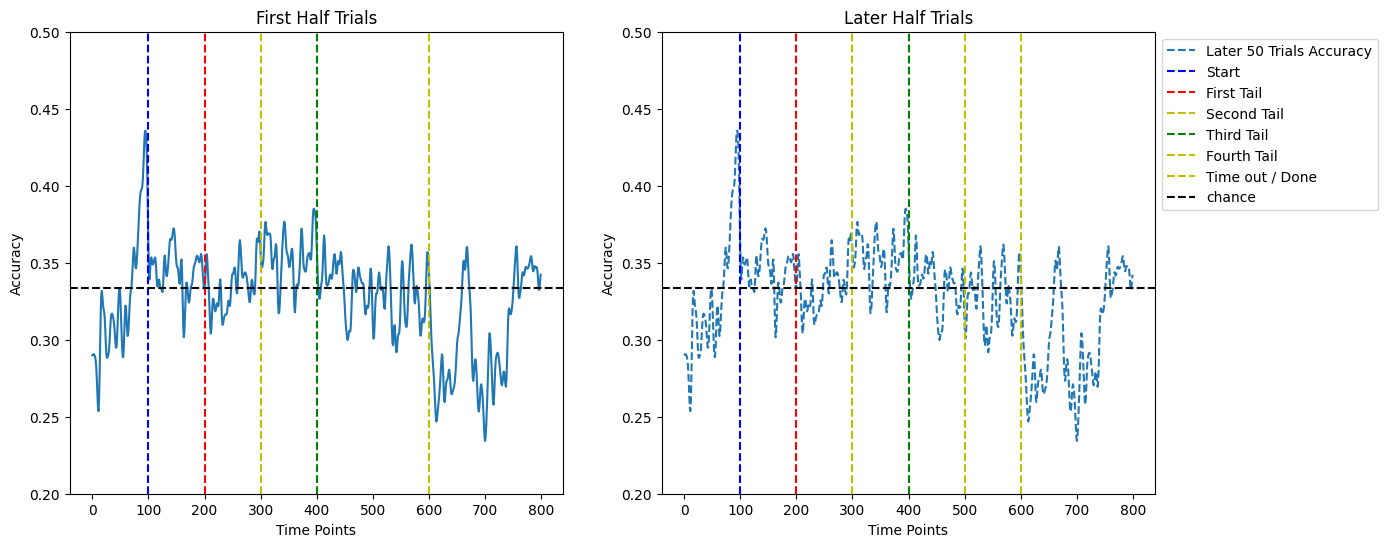

In [36]:
n_time_points = mean_scores_first.shape[0]
# Plot the first 50 trials
smoothed_scores_first = smooth_scores(mean_scores_first)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].plot(np.arange(n_time_points), smoothed_scores_first, label='First 50 Trials Accuracy')
axes[0].axvline(x=100, color='b', linestyle='--', label='Start')
axes[0].axvline(x=200, color='r', linestyle='--', label='First Tail')
axes[0].axvline(x=300, color='y', linestyle='--', label='Second Tail')
axes[0].axvline(x=400, color='g', linestyle='--', label='Third Tail')
axes[0].axvline(x=600, color='y', linestyle='--', label='Time out / Done')
axes[0].axhline(1/n_classes, color='k', linestyle='--', label='chance')
axes[0].set_xlabel('Time Points')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('First Half Trials')
axes[0].set_ylim(0.2, 0.5)

# Plot the later 50 trials
smoothed_scores_later = smooth_scores(mean_scores_later)
axes[1].plot(np.arange(n_time_points), smoothed_scores_later, label='Later 50 Trials Accuracy', linestyle='--')
axes[1].axvline(x=100, color='b', linestyle='--', label='Start')
axes[1].axvline(x=200, color='r', linestyle='--', label='First Tail')
axes[1].axvline(x=300, color='y', linestyle='--', label='Second Tail')
axes[1].axvline(x=400, color='g', linestyle='--', label='Third Tail')
axes[1].axvline(x=500, color='y', linestyle='--', label='Fourth Tail')
axes[1].axvline(x=600, color='y', linestyle='--', label='Time out / Done')
axes[1].axhline(1/n_classes, color='k', linestyle='--', label='chance')
axes[1].set_xlabel('Time Points')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Later Half Trials')
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
axes[1].set_ylim(0.2, 0.5)

